In [43]:
# Libraries related with the neural net
import torch
import torch.nn as nn
import torchvision.models as models
from torch import load
import torchvision.transforms as transforms
import torch

from PIL import Image
import matplotlib.pyplot as plt


In [44]:
# Variables that can be modified
path_model = r"C:\Users\Usuario\Desktop\proyectos\Brain_Tumor_Classification\models\model.pth"
path_image = r"c:\Users\Usuario\Desktop\proyectos\Brain_Tumor_Classification\data\Testing\notumor\Te-no_0010.jpg"
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet50 input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize like ImageNet
])


# Variables that can´t be modified
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 4
LIST_CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']
torch.manual_seed(42)  # Ensures reproducibility
torch.cuda.manual_seed_all(42)

In [45]:
class ResNet50Classifier(nn.Module):
    def __init__(self, state_dict_path=None, num_classes=4):
        super(ResNet50Classifier, self).__init__()
        
        # Load pre-trained ResNet50
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(DEVICE)
        
        # Modify the fully connected layer to adjust for the number of classes
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes).to(DEVICE)
        
        # Load state_dict if provided
        if state_dict_path:
            self.load_state(state_dict_path)

    def forward(self, x):
        x = x.to(DEVICE)
        return self.model(x)
    
    
    def load_state(self, state_dict_path):
        state_dict = torch.load(state_dict_path, map_location=DEVICE)
        
        # Remove "model." prefix if present
        new_state_dict = {}
        for key in state_dict.keys():
            new_key = key.replace("model.", "")  # Remove "model." from key names
            new_state_dict[new_key] = state_dict[key]

        self.model.load_state_dict(new_state_dict, strict=False)  # strict=False to ignore missing extra keys
        print(f"Model state loaded from {state_dict_path}")


In [46]:
# Now we have to create the model with the path of the weights saved before
model = ResNet50Classifier (state_dict_path=path_model, num_classes=NUM_CLASSES)
model.to(DEVICE)

Model state loaded from C:\Users\Usuario\Desktop\proyectos\Brain_Tumor_Classification\models\model.pth


ResNet50Classifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

### How to predict results from a single image

In [47]:
# Loading single image
image = Image.open (path_image).convert("RGB") # Load image

image_transformed = transform(image)  # Apply transformations
image_prepared = image_transformed.unsqueeze(0)  # Add batch dimension (1, 3, 224, 224)
image_prepared = image_prepared.to (DEVICE)


Predicted class: glioma
List prediction classes: tensor([[0.2746, 0.2710, 0.2316, 0.2227]])


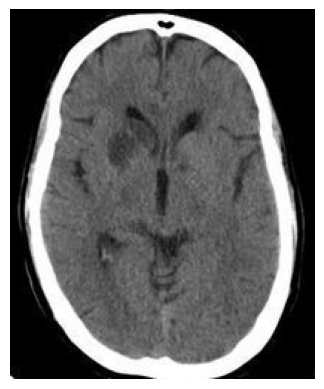

In [48]:
model.eval ()
# Processing single image
with torch.no_grad():  # Disable gradient computation for inference
    outputs = model(image_prepared)  # Forward pass
    probabilities = torch.softmax(outputs, dim=1)  # Convert to probabilities
    predicted_class = torch.argmax(probabilities, dim=1).item()  # Get the class index
    
# Print results and show the image
print(f"Predicted class: {LIST_CLASSES[predicted_class]}")
print (f"List prediction classes: {probabilities}")
plt.imshow(image)
plt.axis("off")  # Hide axis
plt.show()
